In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=a72c1c65923018cb2ae2c8376a57a1ffca32c2189e12ad731ccc4a7a0f04fbec
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [143]:
from pyspark.sql import SparkSession
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col, udf
from pyspark.sql.types import FloatType, StructType, ArrayType

In [144]:
spark = SparkSession.builder \
    .appName("Motor Vehicle Collisions Analysis") \
    .getOrCreate()


In [145]:
data_path = "/content/drive/MyDrive/Motor_Vehicle_Collisions_-_Crashes.csv"
df = spark.read.csv(data_path, header=True, inferSchema=True)

In [146]:
df.printSchema()

root
 |-- CRASH DATE: string (nullable = true)
 |-- CRASH TIME: string (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- ZIP CODE: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- ON STREET NAME: string (nullable = true)
 |-- CROSS STREET NAME: string (nullable = true)
 |-- OFF STREET NAME: string (nullable = true)
 |-- NUMBER OF PERSONS INJURED: string (nullable = true)
 |-- NUMBER OF PERSONS KILLED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS INJURED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS KILLED: integer (nullable = true)
 |-- NUMBER OF CYCLIST INJURED: integer (nullable = true)
 |-- NUMBER OF CYCLIST KILLED: string (nullable = true)
 |-- NUMBER OF MOTORIST INJURED: string (nullable = true)
 |-- NUMBER OF MOTORIST KILLED: integer (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 1: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 2: stri

In [148]:
# Mengonversi kolom 'CRASH DATE' menjadi tipe Date dengan format yang sesuai
df = df.withColumn("CRASH DATE", to_date(col("CRASH DATE"), "MM/dd/yyyy"))

# Menggabungkan kolom tanggal dan waktu menjadi satu string timestamp
df = df.withColumn("CRASH TIMESTAMP", concat_ws(" ", col("CRASH DATE"), col("CRASH TIME")))

# Mengonversi string timestamp ke tipe timestamp
df = df.withColumn("CRASH TIMESTAMP", to_timestamp(col("CRASH TIMESTAMP"), "yyyy-MM-dd H:mm"))

# Menambahkan kolom tahun dengan menggunakan fungsi year
df = df.withColumn("YEAR", year(col("CRASH TIMESTAMP")))

# Menambahkan kolom tahun dengan menggunakan fungsi month
df = df.withColumn("MONTH", month(col("CRASH TIMESTAMP")))

# Menambahkan kolom tahun dengan menggunakan fungsi Hour
df = df.withColumn("HOUR", hour(col("CRASH TIMESTAMP")))

df.printSchema()

root
 |-- CRASH DATE: date (nullable = true)
 |-- CRASH TIME: string (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- ZIP CODE: integer (nullable = true)
 |-- LATITUDE: double (nullable = true)
 |-- LONGITUDE: string (nullable = true)
 |-- LOCATION: string (nullable = true)
 |-- ON STREET NAME: string (nullable = true)
 |-- CROSS STREET NAME: string (nullable = true)
 |-- OFF STREET NAME: string (nullable = true)
 |-- NUMBER OF PERSONS INJURED: string (nullable = true)
 |-- NUMBER OF PERSONS KILLED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS INJURED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS KILLED: integer (nullable = true)
 |-- NUMBER OF CYCLIST INJURED: integer (nullable = true)
 |-- NUMBER OF CYCLIST KILLED: string (nullable = true)
 |-- NUMBER OF MOTORIST INJURED: string (nullable = true)
 |-- NUMBER OF MOTORIST KILLED: integer (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 1: string (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 2: string

# EDA

## Hotspot kecelakaan

In [149]:
hotspots = df.groupBy("BOROUGH").count().orderBy(count("BOROUGH").desc())
hotspots.show(5)

+-------------+------+
|      BOROUGH| count|
+-------------+------+
|     BROOKLYN|280146|
|       QUEENS|238439|
|    MANHATTAN|181268|
|        BRONX|136921|
|STATEN ISLAND| 33243|
+-------------+------+
only showing top 5 rows



## WAKTU KECELAKAAN

In [150]:
time_analysis = df.groupBy("HOUR").count().orderBy(count("HOUR").desc())
time_analysis.show(5)

+----+-----+
|HOUR|count|
+----+-----+
|  16|94671|
|  17|93386|
|  14|88483|
|  15|83942|
|  18|81684|
+----+-----+
only showing top 5 rows



In [151]:
time_analysis = df.groupBy("YEAR").count().orderBy(count("YEAR").desc())
time_analysis.show(5)

+----+------+
|YEAR| count|
+----+------+
|2018|231562|
|2017|231007|
|2016|229822|
|2019|211486|
|2015|126933|
+----+------+
only showing top 5 rows



In [152]:
time_analysis = df.groupBy("MONTH").count().orderBy(count("MONTH").desc())
time_analysis.show(5)

+-----+------+
|MONTH| count|
+-----+------+
|    7|124536|
|    8|122716|
|    6|122197|
|   10|118271|
|    9|114633|
+-----+------+
only showing top 5 rows



## PENYEBAB KECELAKAAN

In [153]:
causes = df.groupBy("CONTRIBUTING FACTOR VEHICLE 1").count().orderBy(count('CONTRIBUTING FACTOR VEHICLE 1').desc())
causes.show(5)

+-----------------------------+------+
|CONTRIBUTING FACTOR VEHICLE 1| count|
+-----------------------------+------+
|                  Unspecified|342029|
|         Driver Inattentio...|307773|
|         Following Too Clo...|101102|
|         Failure to Yield ...| 87462|
|             Backing Unsafely| 56041|
+-----------------------------+------+
only showing top 5 rows



## JENIS KENDARAAN YANG TERLIBAT

In [154]:
vehicle_types = df.groupBy('VEHICLE TYPE CODE 1').count().orderBy(count('VEHICLE TYPE CODE 1').desc())
vehicle_types.show(5)

+--------------------+------+
| VEHICLE TYPE CODE 1| count|
+--------------------+------+
|               Sedan|507562|
|Station Wagon/Spo...|401219|
|   PASSENGER VEHICLE| 86590|
|                Taxi| 47583|
|SPORT UTILITY / S...| 43265|
+--------------------+------+
only showing top 5 rows



## HUBUNGAN ANTARA FAKTOR PENYEBAB DAN JENIS KENDARAAN

In [155]:
cause_vehicle_relation = df.groupBy('CONTRIBUTING FACTOR VEHICLE 1', 'VEHICLE TYPE CODE 1').count().orderBy(count('CONTRIBUTING FACTOR VEHICLE 1').desc())
cause_vehicle_relation.show(5)

+-----------------------------+--------------------+------+
|CONTRIBUTING FACTOR VEHICLE 1| VEHICLE TYPE CODE 1| count|
+-----------------------------+--------------------+------+
|                  Unspecified|               Sedan|126891|
|         Driver Inattentio...|               Sedan|122703|
|         Driver Inattentio...|Station Wagon/Spo...|100512|
|                  Unspecified|Station Wagon/Spo...| 90167|
|         Following Too Clo...|               Sedan| 43648|
+-----------------------------+--------------------+------+
only showing top 5 rows



# MODELING

In [156]:
selected_columns = ['CRASH DATE','YEAR', 'MONTH', 'HOUR','COLLISION_ID', 'BOROUGH','NUMBER OF PERSONS INJURED', 'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED', 'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED', 'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED', 'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1']
df = df.select(selected_columns)
df.printSchema()

root
 |-- CRASH DATE: date (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- HOUR: integer (nullable = true)
 |-- COLLISION_ID: integer (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- NUMBER OF PERSONS INJURED: string (nullable = true)
 |-- NUMBER OF PERSONS KILLED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS INJURED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS KILLED: integer (nullable = true)
 |-- NUMBER OF CYCLIST INJURED: integer (nullable = true)
 |-- NUMBER OF CYCLIST KILLED: string (nullable = true)
 |-- NUMBER OF MOTORIST INJURED: string (nullable = true)
 |-- NUMBER OF MOTORIST KILLED: integer (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 1: string (nullable = true)



## AGGREGATING

In [157]:
# Summing up the injury and fatality related columns
df = df.withColumn('Total Injured',
                              col('NUMBER OF PERSONS INJURED') +
                              col('NUMBER OF PEDESTRIANS INJURED') +
                              col('NUMBER OF CYCLIST INJURED') +
                              col('NUMBER OF MOTORIST INJURED')) \
                  .withColumn('Total Killed',
                              col('NUMBER OF PERSONS KILLED') +
                              col('NUMBER OF PEDESTRIANS KILLED') +
                              col('NUMBER OF CYCLIST KILLED') +
                              col('NUMBER OF MOTORIST KILLED'))

In [158]:
df.printSchema()

root
 |-- CRASH DATE: date (nullable = true)
 |-- YEAR: integer (nullable = true)
 |-- MONTH: integer (nullable = true)
 |-- HOUR: integer (nullable = true)
 |-- COLLISION_ID: integer (nullable = true)
 |-- BOROUGH: string (nullable = true)
 |-- NUMBER OF PERSONS INJURED: string (nullable = true)
 |-- NUMBER OF PERSONS KILLED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS INJURED: integer (nullable = true)
 |-- NUMBER OF PEDESTRIANS KILLED: integer (nullable = true)
 |-- NUMBER OF CYCLIST INJURED: integer (nullable = true)
 |-- NUMBER OF CYCLIST KILLED: string (nullable = true)
 |-- NUMBER OF MOTORIST INJURED: string (nullable = true)
 |-- NUMBER OF MOTORIST KILLED: integer (nullable = true)
 |-- CONTRIBUTING FACTOR VEHICLE 1: string (nullable = true)
 |-- Total Injured: double (nullable = true)
 |-- Total Killed: double (nullable = true)



In [159]:
timeSeriesDf = df.groupBy('MONTH', 'YEAR').sum( 'Total Injured', 'Total Killed')
timeSeriesDf.show(15)

+-----+----+------------------+-----------------+
|MONTH|YEAR|sum(Total Injured)|sum(Total Killed)|
+-----+----+------------------+-----------------+
|   11|2023|              71.0|              3.0|
|    6|2016|           11299.0|             58.0|
|    8|2012|               2.0|              0.0|
|    7|2018|           10982.0|             34.0|
|   11|2021|            8819.0|             46.0|
|    5|2023|             116.0|              0.0|
|    5|2022|            9167.0|             53.0|
|    9|2023|               7.0|              2.0|
|    6|2018|           11231.0|             42.0|
|   12|2020|            6848.0|             42.0|
|    3|2018|            9507.0|             38.0|
|    6|2019|           11850.0|             46.0|
|    7|2021|            9403.0|             57.0|
|    9|2019|           10624.0|             42.0|
|    4|2021|            8026.0|             52.0|
+-----+----+------------------+-----------------+
only showing top 15 rows



In [160]:
columns_to_cast=["MONTH", "YEAR"]

for col_name in columns_to_cast:
    timeSeriesDf = timeSeriesDf.withColumn(col_name, col(col_name).cast("string"))

# Menambahkan kolom "timestamp"
timeSeriesDf = timeSeriesDf.withColumn("timestamp",
                   to_timestamp(concat(col("YEAR"), lit("-"), col("MONTH"), lit("-30"))))

timeSeriesDf.printSchema()

root
 |-- MONTH: string (nullable = true)
 |-- YEAR: string (nullable = true)
 |-- sum(Total Injured): double (nullable = true)
 |-- sum(Total Killed): double (nullable = true)
 |-- timestamp: timestamp (nullable = true)



In [161]:
selected_columns = ['timestamp','sum(Total Killed)', 'sum(Total Injured)', 'YEAR']
timeSeriesDf = timeSeriesDf.select(selected_columns)
timeSeriesDf.printSchema()

root
 |-- timestamp: timestamp (nullable = true)
 |-- sum(Total Killed): double (nullable = true)
 |-- sum(Total Injured): double (nullable = true)
 |-- YEAR: string (nullable = true)



## Missing Vlue

In [162]:
from pyspark.sql import SparkSession, functions as F

spark = SparkSession.builder.appName("MissingValueCheck").getOrCreate()
column_names =timeSeriesDf.columns
null_value_counts = timeSeriesDf.select(*[F.count(F.when(F.col(col).isNull(), col)).alias(col) for col in column_names])
null_value_counts.show()
total_nulls_timeSeriesDf = timeSeriesDf.select(F.sum(F.size(F.array(*[F.col(col).isNull() for col in column_names]))).alias("Total Null Values"))

+---------+-----------------+------------------+----+
|timestamp|sum(Total Killed)|sum(Total Injured)|YEAR|
+---------+-----------------+------------------+----+
|        9|                1|                 1|   1|
+---------+-----------------+------------------+----+



In [163]:
# Handle null values
from pyspark.ml.feature import Imputer
imputer = Imputer(inputCols=["sum(Total Killed)","sum(Total Injured)"],
                  outputCols=["sum(Total Killed)","sum(Total Injured)"])
timeSeriesDf = imputer.fit(timeSeriesDf).transform(timeSeriesDf)

In [164]:
from pyspark.sql import SparkSession, functions as F

spark = SparkSession.builder.appName("MissingValueCheck").getOrCreate()
column_names =timeSeriesDf.columns
null_value_counts = timeSeriesDf.select(*[F.count(F.when(F.col(col).isNull(), col)).alias(col) for col in column_names])
null_value_counts.show()
total_nulls_timeSeriesDf = timeSeriesDf.select(F.sum(F.size(F.array(*[F.col(col).isNull() for col in column_names]))).alias("Total Null Values"))

+---------+-----------------+------------------+----+
|timestamp|sum(Total Killed)|sum(Total Injured)|YEAR|
+---------+-----------------+------------------+----+
|        9|                0|                 0|   1|
+---------+-----------------+------------------+----+



## SPLITING

In [165]:
# Data untuk tahun di bawah 2020
train_set= timeSeriesDf.filter(timeSeriesDf.YEAR < 2020)
train_set.show(5)

# Data untuk tahun di atas 2020
test_set= timeSeriesDf.filter(timeSeriesDf.YEAR > 2020)
test_set.show(5)


+-------------------+-----------------+------------------+----+
|          timestamp|sum(Total Killed)|sum(Total Injured)|YEAR|
+-------------------+-----------------+------------------+----+
|2016-06-30 00:00:00|             58.0|           11299.0|2016|
|2012-08-30 00:00:00|              0.0|               2.0|2012|
|2018-07-30 00:00:00|             34.0|           10982.0|2018|
|2018-06-30 00:00:00|             42.0|           11231.0|2018|
|2018-03-30 00:00:00|             38.0|            9507.0|2018|
+-------------------+-----------------+------------------+----+
only showing top 5 rows

+-------------------+-----------------+------------------+----+
|          timestamp|sum(Total Killed)|sum(Total Injured)|YEAR|
+-------------------+-----------------+------------------+----+
|2023-11-30 00:00:00|              3.0|              71.0|2023|
|2021-11-30 00:00:00|             46.0|            8819.0|2021|
|2023-05-30 00:00:00|              0.0|             116.0|2023|
|2022-05-30 00:

## FEATURES IMPORTANCES

In [166]:
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
def show_matrix(matrix):
    """
    function to print a matrix on screen
    """
    print(matrix.collect()[0][matrix.columns[0]].toArray())
    print()

vector_col = "features"
assembler = VectorAssembler(inputCols=["sum(Total Killed)"], outputCol=vector_col)
df_vector = assembler.transform(timeSeriesDf).select(vector_col)

matrix_pearson = Correlation.corr(df_vector, vector_col)    #pearson is default
matrix_spearman = Correlation.corr(df_vector, vector_col, "spearman")
show_matrix(matrix_pearson)
show_matrix(matrix_spearman)

[[1.]]

[[1.]]



## Times Series GBT: Total Killed

## Feature Scaling

In [167]:
from pyspark.sql.functions import mean as _mean, stddev as _stddev, col, udf
from pyspark.sql.types import FloatType, StructType, ArrayType

train_set_stats = train_set.select(
    _mean(col('sum(Total Killed)')).alias('mean'),
    _stddev(col('sum(Total Killed)')).alias('std')
).collect()
mean = train_set_stats[0]['mean']    #mean of close prices
std = train_set_stats[0]['std']    #standard deviation of close prices

@udf(returnType=FloatType())
def tanh_estimator(x):
    """
    user defined function, applies tanh estimator's formula to a feature value x
    """
    return (float)(0.5 * (np.tanh(0.01*(x-mean)/std) + 1))

def scale_transform(timeSeriesDf):
    """
    tranforms a dataframe applying tanh estimator udf
    """
    return timeSeriesDf.select("YEAR", tanh_estimator("sum(Total Killed)").alias("sum(Total Killed)"))

scaled_train_set = scale_transform(train_set)
scaled_test_set = scale_transform(test_set)

## Sliding Window

In [168]:
from pyspark.sql.window import Window

def slide_window(df, window_size):
    w=Window.orderBy("YEAR")
    indexed_df=timeSeriesDf.withColumn("Index", row_number().over(w)).select("Index","sum(Total Killed)")
    schema=StructType([StructField("sum(Total Killed)", ArrayType(FloatType()),False)])
    X=spark.createDataFrame(spark.sparkContext.emptyRDD(),schema )
    y=spark.createDataFrame(spark.sparkContext.emptyRDD(),FloatType())
    length=indexed_df.count()
    for i in range(window_size+1, length+1):
        new_df=indexed_df.where(col("Index").between(i-window_size, i-1)).select("sum(Total Killed)")
        new_row=new_df.agg(collect_list("sum(Total Killed)").alias("sum(Total Killed)"))
        X=X.union(new_row)
        new_row = indexed_df.where(col("Index") == i).select("sum(Total Killed)")
        y=y.union(new_row)

    return X, y

In [169]:
window=30    #window size
X_train,y_train=slide_window(scaled_train_set, window)    #slide window on train set
X_test,y_test=slide_window(scaled_test_set, window)    #slide window on test set

## Merge X&Y

In [170]:
def merge_X_y(X, y):
    """
    merges two dataframes column-wise
    """
    schema = StructType(X.schema.fields + y.schema.fields)
    X_y = X.rdd.zip(y.rdd).map(lambda x: x[0]+x[1])
    return spark.createDataFrame(X_y, schema)

X_y_train = merge_X_y(X_train, y_train)
X_y_test = merge_X_y(X_test, y_test)

## Vectorization Window

In [171]:
from pyspark.ml.linalg import Vectors, VectorUDT
from pyspark.sql.functions import udf
from pyspark import StorageLevel

list_to_vector_udf=udf(lambda l: Vectors.dense(l), VectorUDT())
def assemble_window(X_y):
    """
    applies list_to_vector_udf to given dataframe
    """
    return X_y.select(list_to_vector_udf(X_y["sum(Total Killed)"]).alias("features"), X_y["value"].alias("label"))
X_y_train_vec=assemble_window(X_y_train)
X_y_test_vec=assemble_window(X_y_test)

## Hyperparameter tuning/model selection/evaluation

In [172]:
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.evaluation import RegressionEvaluator

def cross_validate(model, param_grid, df):
    evaluator=RegressionEvaluator(metricName="rmse")
    cv=CrossValidator(estimator=model, estimatorParamMaps=param_grid, evaluator=evaluator)
    validated_model=cv.fit(df)
    return validated_model

## Model GBT

In [173]:
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GBTRegressor
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

# Inisialisasi Spark session
spark = SparkSession.builder.appName("GBTRegressionTimeSeries").getOrCreate()

# Contoh: Membuat lag features
from pyspark.sql.window import Window
from pyspark.sql.functions import lag

windowSpec = Window.orderBy("Year")
timeSeriesDf = timeSeriesDf.withColumn("lag1", lag("sum(Total Killed)", 1).over(windowSpec))
timeSeriesDf = timeSeriesDf.withColumn("lag2", lag("sum(Total Killed)", 2).over(windowSpec))

# Buang nilai null karena lag menghasilkan nilai null untuk beberapa baris pertama
timeSeriesDf = timeSeriesDf.na.drop()

# Vektor fitur
assembler = VectorAssembler(inputCols=["lag1", "lag2"], outputCol="features")
timeSeriesDf = assembler.transform(timeSeriesDf)

# Bagi data menjadi data latih dan data uji
train_data, test_data = timeSeriesDf.randomSplit([0.8, 0.2], seed=42)

# Inisialisasi model GBTRegressor
gbt_r = GBTRegressor(featuresCol="features", labelCol="sum(Total Killed)")

# Parameter grid untuk tuning
param_grid = ParamGridBuilder() \
    .addGrid(gbt_r.maxDepth, [4, 8, 12]) \
    .addGrid(gbt_r.featureSubsetStrategy, ['0.33', '0.66']) \
    .build()

# Evaluator
evaluator = RegressionEvaluator(labelCol="sum(Total Killed)", predictionCol="prediction", metricName="rmse")

# CrossValidator
crossval = CrossValidator(estimator=gbt_r,
                          estimatorParamMaps=param_grid,
                          evaluator=evaluator,
                          numFolds=5)

# Latih model menggunakan CrossValidator
cvModel = crossval.fit(train_data)

# Parameter terbaik
bestModel = cvModel.bestModel
max_depth = bestModel.getMaxDepth()
subsample = bestModel.getFeatureSubsetStrategy()

print("maxDepth of best model -> ", max_depth)
print("featureSubsetStrategy of best model -> ", subsample)

# Prediksi pada data uji
predictions = bestModel.transform(test_data)

# Evaluasi model
RMSE = evaluator.evaluate(predictions)
print("RMSE of best model on unseen data -> ", RMSE)

maxDepth of best model ->  4
featureSubsetStrategy of best model ->  0.33
RMSE of best model on unseen data ->  18.87902811873125


## Visualisasi Prediksi GBT

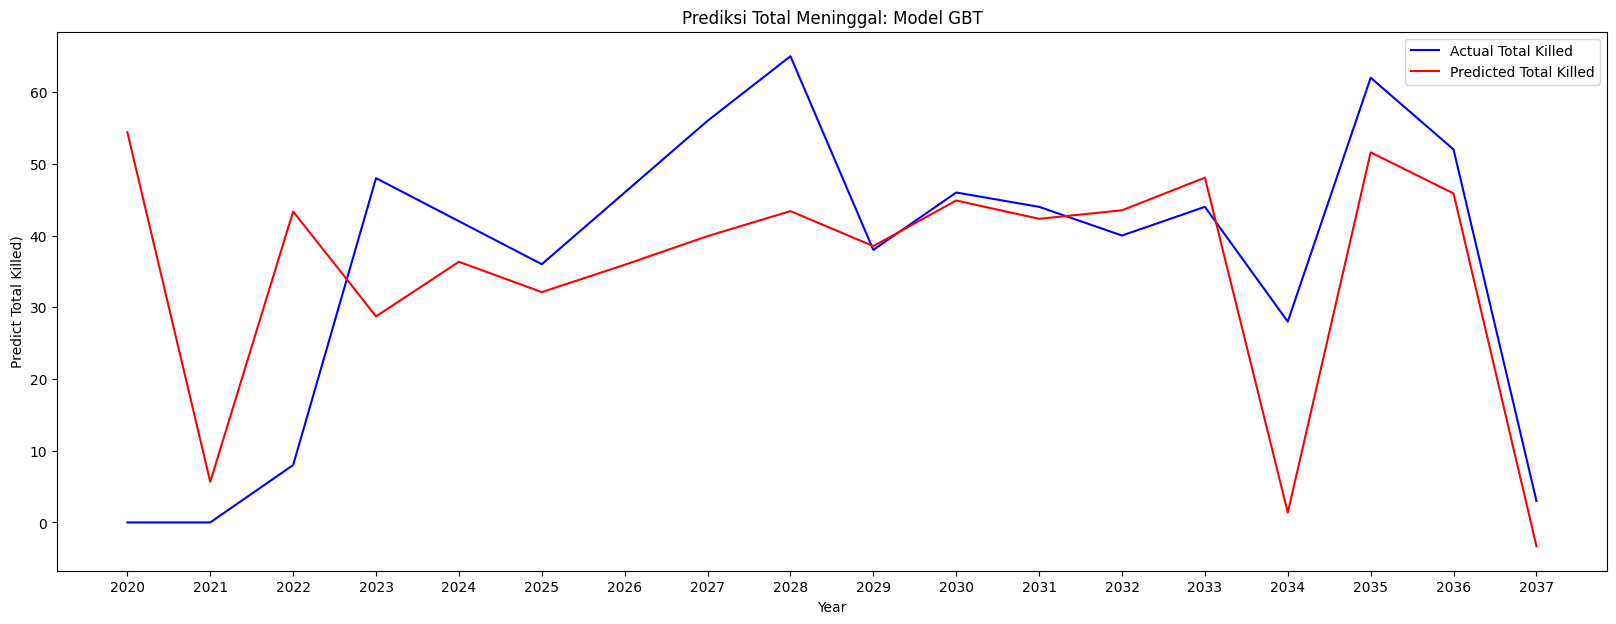

In [185]:
import matplotlib.pyplot as plt
import numpy as np

def plot_predictions(predictions):
  """
  Plots two lines representing predicted and actual prices.
  """
  pandas_df = predictions.select('sum(Total Killed)', 'prediction').toPandas()

  if 'Year' in pandas_df.columns:
      years = pandas_df['Year'].values
  else:
      years = np.arange(2020, 2020 + pandas_df.shape[0])

  plt.figure(figsize=(20, 7))
  plt.title("Prediksi Total Meninggal: Model GBT")
  plt.plot(years, pandas_df['sum(Total Killed)'].values, label='Actual Total Killed', color='blue')
  plt.plot(years, pandas_df['prediction'].values, label='Predicted Total Killed', color='red')
  plt.xticks(years)  # Set x-axis ticks to extracted years
  plt.xlabel('Year')
  plt.ylabel('Predict Total Killed)')
  plt.legend()
  plt.show()

# Gunakan fungsi plot_predictions
plot_predictions(predictions)